In [42]:
import matplotlib.pyplot as plt
import json
import requests
import numpy as np
import time
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
%matplotlib inline

In [43]:
def get_temp(elem):
    return elem['Measurements']['Temperature']['value']

def get_measure(elem, key):
    return elem['Measurements'][key]['value']

def get_timestamp(elem):
    return elem['Timestamp']
# Carbon Dioxide concentration

In [44]:
int(round(time.time() * 1000))

1543076359302

In [45]:
URL_TEMPLATE = "https://apigtw.vaisala.com/hackjunction2018/saunameasurements/history?SensorID={}&before={}&after={}"
TIME_NOW = int(round(time.time() * 1000))

def load_to_file_json(sensor_id):
    now =   TIME_NOW
    start = 1542924742000
    delta = 3600000
    
    timestamps_all = []
    measures_all = defaultdict(list)
    
#     cnt = 0
    for timestamp in range(start, now, delta):
#         cnt += 1
#         if cnt == 3:
#             break
        before = timestamp + delta
        after = timestamp
        response = requests.get(URL_TEMPLATE.format(sensor_id, before, after))
        json_array = json.loads(response.text)
        
        if len(json_array) > 0:
            timestamps_all.append([get_timestamp(x) for x in json_array])
            for item in json_array:
                for measure in item['Measurements'].items():
                    measures_all[measure[0]].append(measure[1]['value'])
    
    timestamps_all = np.concatenate(timestamps_all)
    df = pd.DataFrame()
    df['timestamps'] = timestamps_all
    for measure in measures_all.items():
        df[measure[0]] = measure[1]

    df.to_csv("data/{}.csv".format(sensor_id), index=False)

In [23]:
# load_to_file_json('Bench1')

In [26]:
# load_to_file_json('Ceiling1')

In [29]:
# load_to_file_json('Stove1')

In [31]:
# load_to_file_json('Floor1')

In [33]:
# load_to_file_json('Doorway1')

In [37]:
# load_to_file_json('Outdoor1')

In [47]:
# load_to_file_json('Stove2')

In [49]:
# sensors = ['Ceiling1', 'Ceiling2', 'Stove1', 'Stove2',
# 'Bench1', 'Bench2', 'Bench3', 'Floor1', 'Doorway1', 'Outdoor1']

In [485]:
df = pd.read_csv("data/Stove1.csv")
df = df.sort_values(by='timestamps')
df.index = df['timestamps']
# df = df.iloc[8 * 60 * 60: 15 * 60 * 60]
df = df.iloc[8 * 60 * 60: ]

In [165]:
df.head()

,timestamps,Carbon Dioxide concentration,Temperature
timestamps,,,
1542924742055,1542924742055,379.0,22.33
1542924743055,1542924743055,379.0,22.33
1542924744068,1542924744068,379.0,22.33
1542924745255,1542924745255,379.0,22.33
1542924746109,1542924746109,379.0,22.33


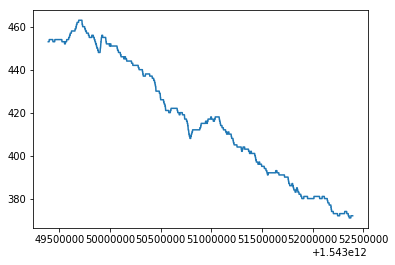

In [103]:
df = df[:3000]
plt.plot(df['timestamps'], df['Carbon Dioxide concentration'])

In [247]:
# 6 * x + 370 = 1500
rashod = (1700 - 370) / 6
rashod

221.66666666666666

In [248]:
rashod_levels = [rashod * x + 370 for x in range(16)]

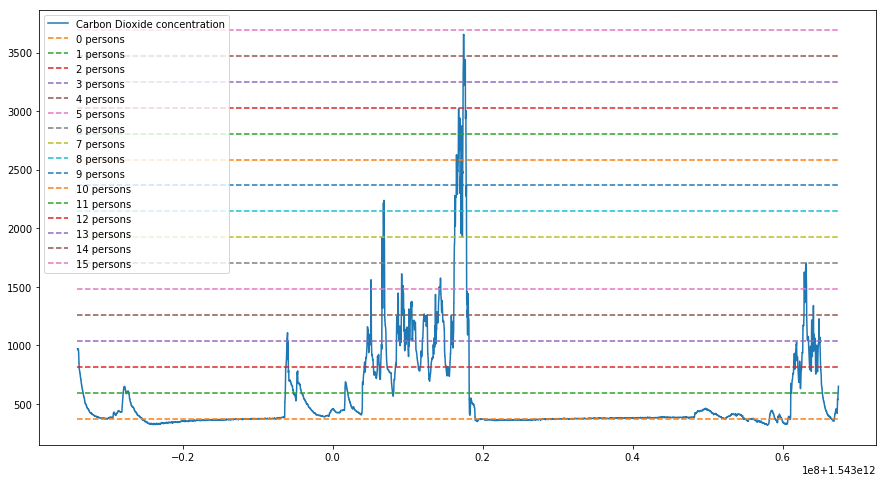

In [249]:
OX = (df['timestamps'].iloc[0], df['timestamps'].iloc[-1])
plt.figure(figsize=(15, 8))
plt.plot(df['timestamps'], df['Carbon Dioxide concentration'])
for i, lvl in enumerate(rashod_levels):
    plt.plot(OX,  [lvl, lvl], '--', label='{} persons'.format(i))
plt.legend(loc='best')
plt.show()


In [384]:
GOOD_TEMP = 65

good_time = df[df['Temperature'] > GOOD_TEMP]
bad_time = df[~(df['Temperature'] > GOOD_TEMP)]

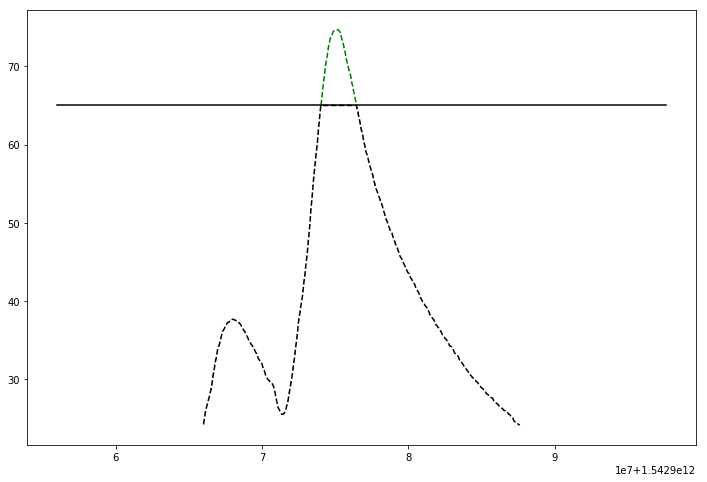

In [431]:
plt.figure(figsize=(12,8))
plt.plot(bad_time['timestamps'], bad_time['Temperature'], '--', color='black')
plt.plot(good_time['timestamps'], good_time['Temperature'], '--', color='green')
plt.plot(bad_time['timestamps'].iloc[np.array([0, -1])] + np.array((-10000000, +10000000)),
         [GOOD_TEMP, GOOD_TEMP], color='black')

plt.show()

In [487]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

temp = df['Temperature'].values
timestamps = df['timestamps'].values
kkk = 1000
dvt = [temp[i] - temp[i - kkk] for i in range(kkk, len(temp))]
dvt2 = [dvt[i] - dvt[i - kkk] for i in range(kkk, len(dvt))]
dvt = dvt[kkk: ]
dvt = moving_average(dvt, n=1 * 60)
dvt2 = moving_average(dvt2, n=1 * 60)


temp = temp[len(temp) - len(dvt2):]
timestamps = timestamps[len(timestamps) - len(dvt2):]

In [488]:
len(dvt2), len(dvt), len(temp), len(timestamps)

(102786, 102786, 102786, 102786)

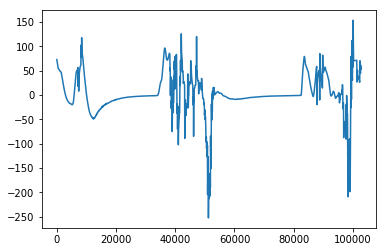

In [489]:
plt.plot(dvt)

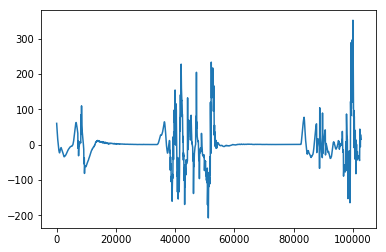

In [490]:
plt.plot(dvt2)

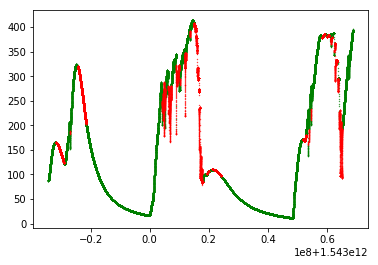

In [493]:
def is_need_to_podikinut_drov():
    return (dvt < 10) & (dvt2 < -3)

plt.plot()
ids = is_need_to_podikinut_drov()

plt.plot(timestamps[~ids], temp[~ids], '.', markersize=0.70, color = 'green')
plt.plot(timestamps[ids], temp[ids], '.', markersize=0.7, color = 'red')

In [495]:
plot_df = pd.DataFrame()
plot_df['podkin_drova'] = ids
plot_df['timestamps'] = timestamps
plot_df['temp'] = temp

plot_df.to_csv('data/podkin_drova.csv', index=False)